# Data Preparation

In [1]:

import time
start_notebook = time.time()
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# %cd ..
# %pwd

In [3]:
# Option to generate mock data
generate_mock_data = False # Set to True to generate mock data
max_mock_depth_ft = 2000 # Define maximum depth for mock data
well_name = "LLB-10"
if not generate_mock_data:
  # Load data from local directory
    data = pd.read_csv(f"../data/processed/{well_name}.csv", sep=',')
if generate_mock_data:
    print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name}...")
    mock_depth_step = 0.5
    mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
    num_mock_rows = len(mock_dept_values)

    mock_data_dict = {'DEPT': mock_dept_values}

    feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP'] #complete with all necessary features available in LLB-10

    for col in feature_cols_for_mock:
        mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

    mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

    data = pd.DataFrame(mock_data_dict)

    print(f"Mock data generated for well {well_name} with {num_mock_rows} rows and columns: {list(data.columns)}.")
    print("Mock data head:")
    print(data.head())

In [4]:
feature_cols = ['DRHO','GR','SR','MR','DR','NPHI','RHOB']

In [5]:
df=data[feature_cols]

In [6]:
df = df.fillna(df.mean())

In [7]:
df

,DRHO,GR,SR,MR,DR,NPHI,RHOB
0,0.051,88.200,0.737,0.875,0.741,0.4841,2.103
1,0.050,85.650,0.741,0.874,0.742,0.4744,2.130
2,0.064,79.358,0.779,0.900,0.743,0.4845,2.177
3,0.077,74.004,0.802,0.917,0.744,0.5475,2.184
4,0.081,78.938,0.840,0.973,0.744,0.6065,2.142
...,...,...,...,...,...,...,...
7156,0.206,48.022,1.897,1.943,2.186,0.3222,2.595
7157,0.158,51.742,1.858,1.981,2.194,0.3199,2.555
7158,0.089,54.041,1.919,2.015,2.245,0.3278,2.477
7159,0.052,52.710,1.883,1.962,2.291,0.3315,2.432


## Train/Test Splitting

In [8]:
# Misalkan 'data' adalah DataFrame Anda dan 'df' adalah fitur yang telah Anda ekstrak
X = df  # Fitur
y = data['hydrocarbon_formation_class']  # Label

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
X_train.describe()

,DRHO,GR,SR,MR,DR,NPHI,RHOB
count,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000,5728.000000
mean,0.151581,60.151726,1.231823,1.423017,1.091510,0.410583,2.341646
std,0.104705,11.011582,0.723964,1.023737,0.232002,0.052945,0.116581
min,-0.196000,19.683000,0.540000,0.559000,0.603000,0.136700,1.460000
25%,0.089000,53.034000,1.007000,1.086000,0.957000,0.382800,2.285000
50%,0.133000,62.135000,1.095000,1.224000,1.038000,0.407900,2.351000
75%,0.186000,68.128500,1.239000,1.423000,1.161000,0.442825,2.409000
max,0.824000,90.688000,14.701000,24.142000,2.924000,0.623900,3.433000


## Data Imbalance Handling

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
# X_train and y_train are available from CELL INDEX 10
print("Original training data shape:", X_train.shape, y_train.shape)
print("Original training class distribution:\n", y_train.value_counts())

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape of training data after SMOTE:", X_train_smote.shape, y_train_smote.shape)
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# Update X_train and y_train to be the oversampled versions
X_train = X_train_smote
y_train = y_train_smote

Original training data shape: (5728, 7) (5728,)
Original training class distribution:
 hydrocarbon_formation_class
0    5368
1     360
Name: count, dtype: int64

Shape of training data after SMOTE: (10736, 7) (10736,)
Class distribution after SMOTE:
 hydrocarbon_formation_class
0    5368
1    5368
Name: count, dtype: int64


## Apply Quantile Transformation

In [12]:
from sklearn.preprocessing import QuantileTransformer
def transform_quantile(X_train, X_test, X):
    qt_transformer = QuantileTransformer(output_distribution='normal')
    dfs = [X_train, X_test, X]
    qt_dfs = [None,None,None]
    for i, df in enumerate(dfs):
        if (i == 0): #only perform fit_transform on training data
            qt_dfs[i] = pd.DataFrame(qt_transformer.fit_transform(df))
        else:
            qt_dfs[i] = pd.DataFrame(qt_transformer.transform(df))
        qt_dfs[i].columns = df.columns.values
        qt_dfs[i].index = df.index.values
    return qt_dfs[0], qt_dfs[1], qt_dfs[2] #X_train, X_test, X

In [13]:
X_train, X_test, X = transform_quantile(X_train, X_test, X)

## Feature Scaling

karena menggunakan Quatile transformation dengan output gaussian, masing masing kolom secara otomatis ditransformasi ke distribusi normal baku, atau distribusi normal dengan rataan nol dan standar deviasi 1, oleh karena itu tidak diperlukan tambahan scaling.

In [14]:
X_train.describe()

,DRHO,GR,SR,MR,DR,NPHI,RHOB
count,10736.000000,10736.000000,10736.000000,10736.000000,10736.000000,10736.000000,10736.000000
mean,-0.000558,0.001555,0.003556,0.003140,0.004414,0.002300,-0.000205
std,1.001648,1.001161,1.002331,1.001442,1.002993,1.000758,1.000161
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.670557,-0.669157,-0.673702,-0.668987,-0.672129,-0.668302,-0.671995
50%,-0.000892,0.004890,0.002515,0.000226,0.003183,0.005311,0.000000
75%,0.673292,0.677828,0.680079,0.674807,0.676557,0.674792,0.673702
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


# Training setup

In [15]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV


train_accuracy={}
test_accuracy={}

crossValidation_accuracy={}

models = {} #sklearn models

times = {}

pred = {}

pred_times = {}

# Models

## SVM

In [16]:
model_name = "SVM"

In [17]:
from sklearn.svm import SVC as SklearnSVC

In [18]:
# Parameter grid for both models
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# 1) scikit-learn SVM with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnSVC(kernel='rbf'),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
scikit-learn GridSearchCV training time (SVM) : 5.51 seconds
scikit-learn Best parameters (SVM): {'C': 10, 'gamma': 'scale'}


## K-Nearest Neighbors

In [19]:
model_name = "KNN"

In [20]:
from sklearn.neighbors import KNeighborsClassifier as SklearnKNeighborsClassifier

In [21]:
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 1) scikit-learn KNN with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnKNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start

print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
scikit-learn GridSearchCV training time (KNN) : 0.70 seconds
scikit-learn Best parameters (KNN): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Random Forest

In [22]:
model_name = "RF"

In [23]:
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier

In [24]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
}

# 1) scikit-learn RandomForest with GridSearchCV
models[model_name] = GridSearchCV(
    estimator=SklearnRandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5, # Using 3-fold CV for RF due to potentially longer training times
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
models[model_name].fit(X_train, y_train)
time_end = time.time()
times[model_name] = time_end - time_start



print(f"scikit-learn GridSearchCV training time ({model_name}) : {times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {models[model_name].best_params_}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
scikit-learn GridSearchCV training time (RF) : 25.99 seconds
scikit-learn Best parameters (RF): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# LLB-10 Prediction & Model Evaluation

--- Evaluating: SVM ---

-- scikit-learn --
Prediction Duration: 0.24 seconds
Train Accuracy: 0.9812
Test Accuracy: 0.9700
Best Cross-Validation Score: 0.9772
Training Duration: 5.51 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1343
           1       0.70      0.91      0.79        90

    accuracy                           0.97      1433
   macro avg       0.85      0.94      0.89      1433
weighted avg       0.98      0.97      0.97      1433

Confusion Matrix (Test Set):


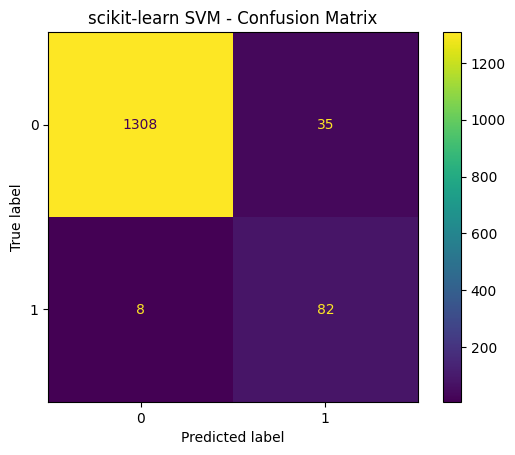



--- Evaluating: KNN ---

-- scikit-learn --
Prediction Duration: 0.07 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9623
Best Cross-Validation Score: 0.9743
Training Duration: 0.70 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1343
           1       0.63      0.96      0.76        90

    accuracy                           0.96      1433
   macro avg       0.81      0.96      0.87      1433
weighted avg       0.97      0.96      0.97      1433

Confusion Matrix (Test Set):


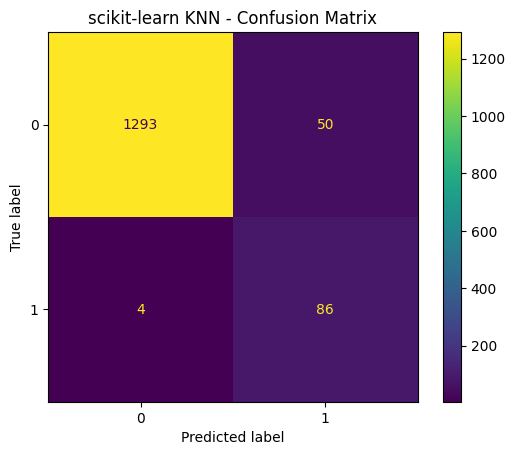



--- Evaluating: RF ---

-- scikit-learn --
Prediction Duration: 0.03 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9721
Best Cross-Validation Score: 0.9802
Training Duration: 25.99 seconds
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1343
           1       0.75      0.84      0.79        90

    accuracy                           0.97      1433
   macro avg       0.87      0.91      0.89      1433
weighted avg       0.97      0.97      0.97      1433

Confusion Matrix (Test Set):


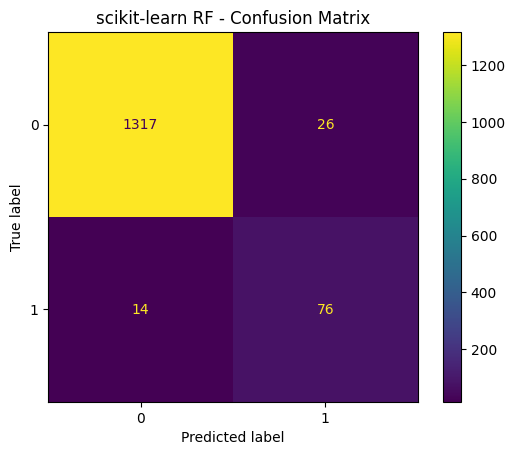




Summary of Accuracies and Times:
Train Accuracies: {'SVM': 0.9811847988077497, 'KNN': 1.0, 'RF': 1.0}
Test Accuracies: {'SVM': 0.9699930216329379, 'KNN': 0.9623168178646196, 'RF': 0.9720865317515701}
Cross-Validation Accuracies: {'SVM': np.float64(0.9771794951857817), 'KNN': np.float64(0.9742921351433165), 'RF': np.float64(0.9801602686698949)}
Training Times: {'SVM': 5.513788223266602, 'KNN': 0.695636510848999, 'RF': 25.994237661361694}
Prediction Times: {'SVM': 0.23663330078125, 'KNN': 0.07205772399902344, 'RF': 0.03425741195678711}


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Comparison and Evaluation ---
model_names = list(models.keys()) # Assuming cu_models will have the same keys if cuML is available

for model_name in model_names:
    print(f"--- Evaluating: {model_name} ---")

    # --- scikit-learn model ---
    if model_name in models:
        print("\n-- scikit-learn --")
        best_sk_model = models[model_name].best_estimator_

        # Predictions
        y_pred_train_sk = best_sk_model.predict(X_train)
        y_pred_test_sk = best_sk_model.predict(X_test)
        start_time = time.time()
        pred[model_name] = best_sk_model.predict(X)
        end_time = time.time()
        pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {pred_times[model_name]:.2f} seconds")

        # Accuracy
        train_accuracy_sk = accuracy_score(y_train, y_pred_train_sk)
        test_accuracy_sk = accuracy_score(y_test, y_pred_test_sk)
        train_accuracy[model_name] = train_accuracy_sk
        test_accuracy[model_name] = test_accuracy_sk
        print(f"Train Accuracy: {train_accuracy_sk:.4f}")
        print(f"Test Accuracy: {test_accuracy_sk:.4f}")

        # Cross-validation score
        cv_score_sk = models[model_name].best_score_
        crossValidation_accuracy[model_name] = cv_score_sk
        print(f"Best Cross-Validation Score: {cv_score_sk:.4f}")

        # Duration
        print(f"Training Duration: {times[model_name]:.2f} seconds")

        print("Classification Report (Test Set):")
        print(classification_report(y_test, y_pred_test_sk))

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_sk = confusion_matrix(y_test, y_pred_test_sk)
        disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=best_sk_model.classes_)
        disp_sk.plot()
        plt.title(f"scikit-learn {model_name} - Confusion Matrix")
        plt.show()


    print("\n" + "="*40 + "\n")

print("\nSummary of Accuracies and Times:")
print("Train Accuracies:", train_accuracy)
print("Test Accuracies:", test_accuracy)
print("Cross-Validation Accuracies:", crossValidation_accuracy)
print("Training Times:", times)
print("Prediction Times:", pred_times)

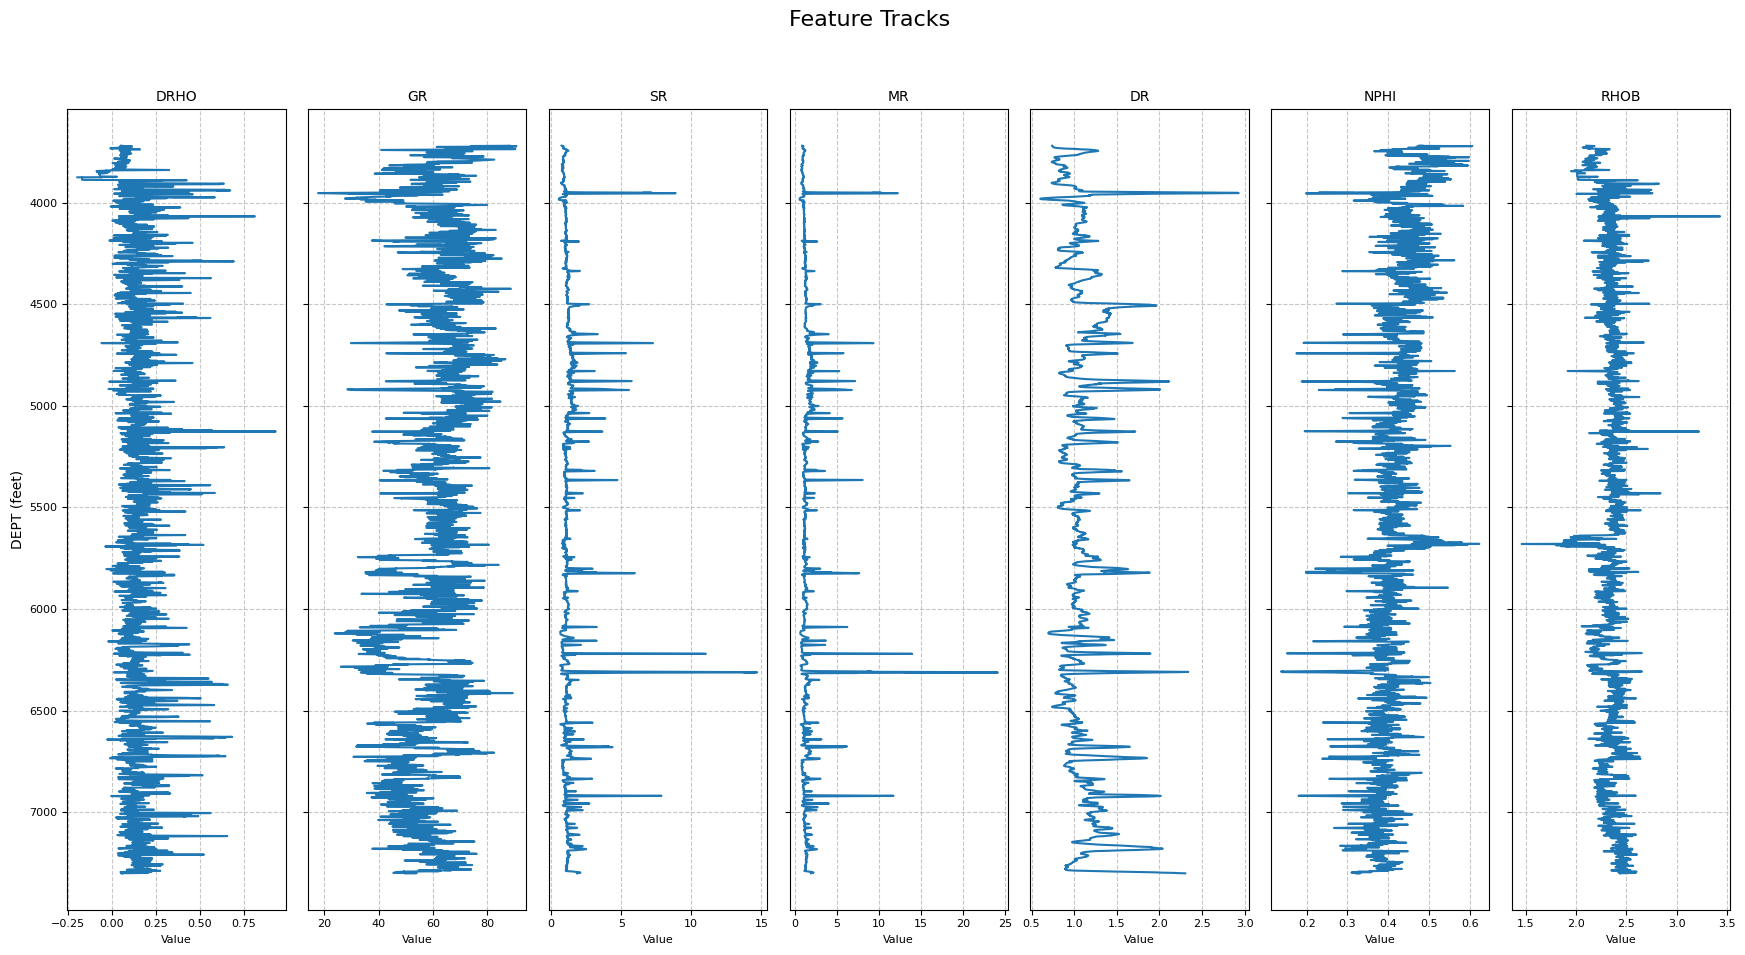

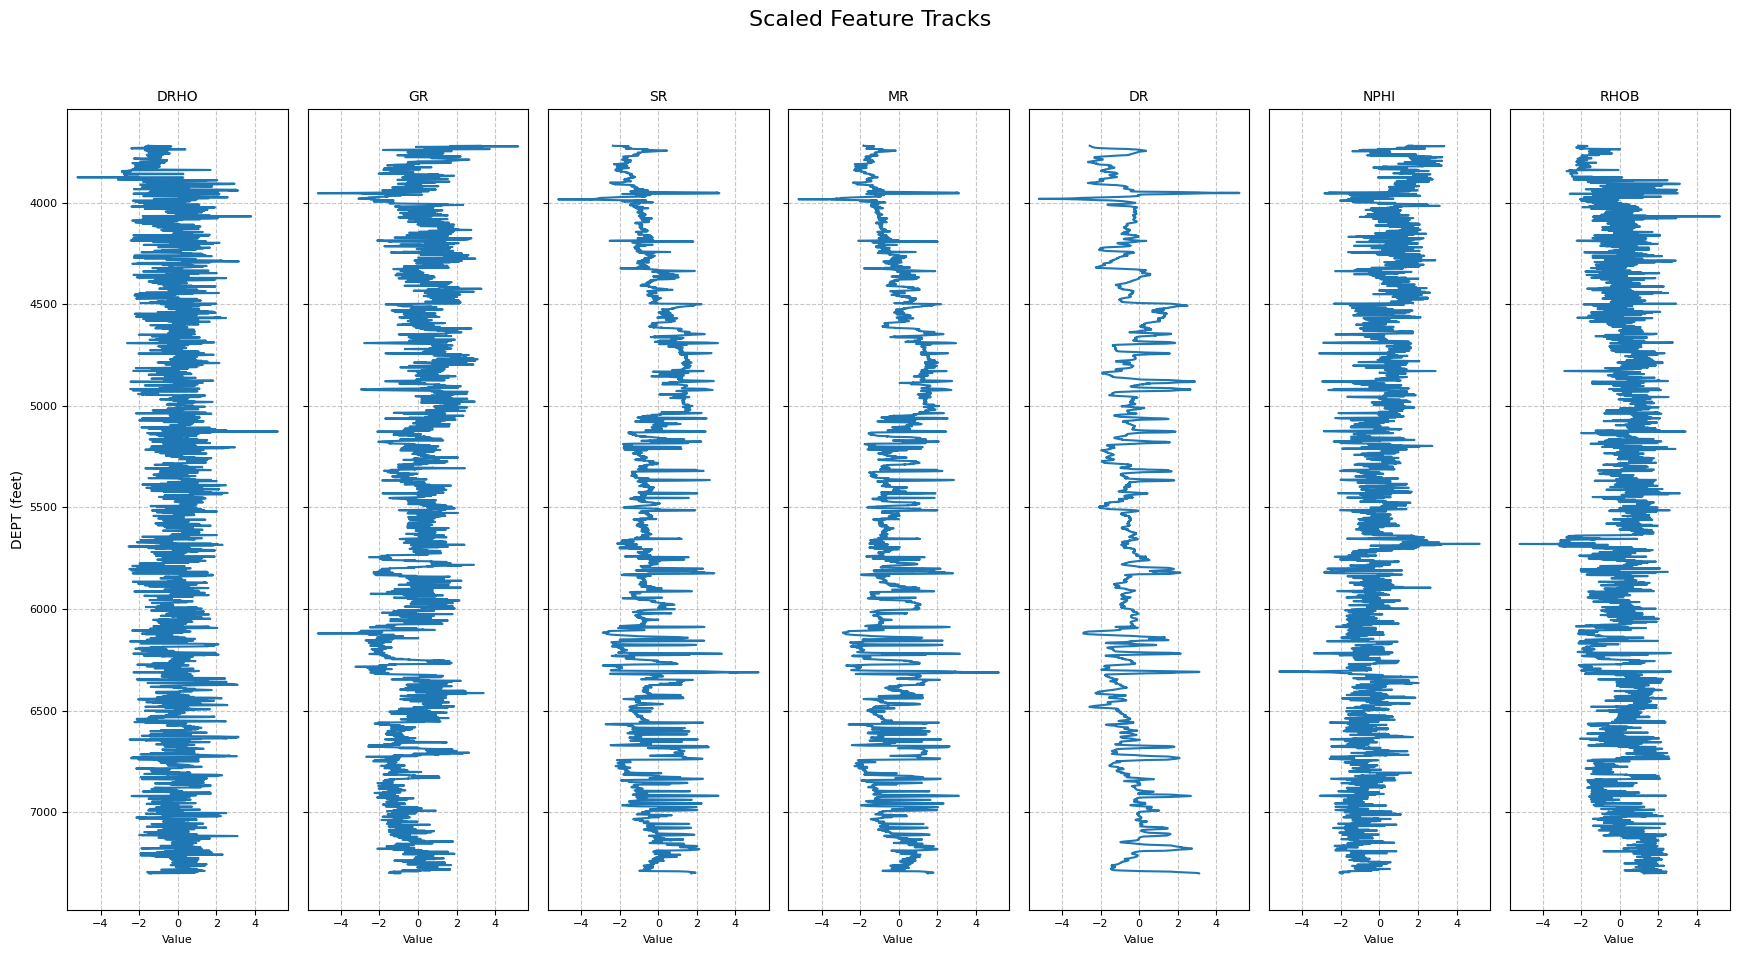

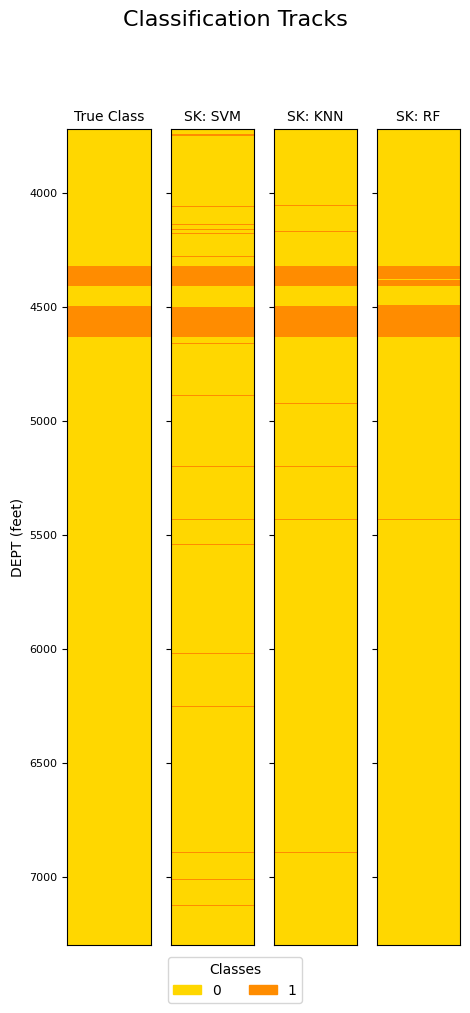

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Ensure all necessary variables are defined from previous cells:
# data, df, y, pred
# X (to get the index for aligning predictions if they are numpy arrays)

if 'DEPT' not in data.columns:
    print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
else:
    depth_column = data['DEPT']
    feature_names = df.columns.tolist()

    # Prepare labels and predictions
    true_labels = y
    all_predictions_to_plot = {}
    all_predictions_to_plot['True Labels'] = true_labels
    for model_name, preds in pred.items():
        all_predictions_to_plot[f'SK: {model_name}'] = preds

    # Define colors for classes
    if isinstance(true_labels, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels))
    else:
        unique_classes = np.sort(true_labels.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])


    # --- Figure 1: feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for feature tracks.")

    # --- Figure 2: scaled feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(X[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for scaled feature tracks.")

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_to_plot)
    if num_classification_plots > 0:
        # Adjust figsize: width per plot can be smaller for classification tracks
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle("Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                if not predictions_data.index.equals(X.index):
                    # This should ideally not happen with consistent data handling
                    # For safety, one might reindex or ensure alignment upstream
                    print(f"Warning: Index mismatch for {title}. Plotting may be incorrect.")
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=X.index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0: # Set Y-axis label only for the first plot in this figure
                ax.set_ylabel("DEPT (feet)", fontsize=10)


        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print("No classification data to plot.")


# Test Wells

## Configuration

In [27]:
# Configuration for test wells
test_wells = ['LLD-14']  # Add more wells here: ["LLD-14", "WELL-X", "WELL-Y"]

# Initialize dictionaries to store results for all test wells
test_wells_data = {}

#! test_feature_cols isnt used in the current 
#! implementation until missing column imputation is
#! implemented. for now, feature_cols are used directly. 
#! Test wells & training well feature columns must be the same
test_feature_cols = {
    'LLD-14': ['DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR'],
}
test_wells_features = {}
test_wells_features_scaled = {}
test_wells_true_labels = {}
test_wells_pred = {}
test_wells_pred_times = {}
test_wells_accuracy = {}

print(f"Configured test wells: {test_wells}")

Configured test wells: ['LLD-14']


## Load Test Wells Data

In [28]:
# Load data for all test wells
for well_name_test in test_wells:
    print(f"\n--- Loading data for {well_name_test} ---")
    
    if not generate_mock_data:
            # Load data from local directory
            test_wells_data[well_name_test] = pd.read_csv(f"../data/processed/{well_name_test}.csv", sep=',')
    else:
        # Generate mock data for test well if needed
        print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name_test}...")
        mock_depth_step = 0.5
        mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
        num_mock_rows = len(mock_dept_values)

        mock_data_dict = {'DEPT': mock_dept_values}

        feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP']

        for col in feature_cols_for_mock:
            mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

        mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

        test_wells_data[well_name_test] = pd.DataFrame(mock_data_dict)

    print(f"{well_name_test} data shape: {test_wells_data[well_name_test].shape}")
    print(f"{well_name_test} data columns: {list(test_wells_data[well_name_test].columns)}")
    print(f"{well_name_test} data head:")
    print(test_wells_data[well_name_test].head())


--- Loading data for LLD-14 ---
LLD-14 data shape: (3507, 46)
LLD-14 data columns: ['DEPT', 'B', 'B1', 'BADHOLE', 'CT', 'CXO', 'DIFFND', 'DRHO', 'DT', 'FTEMP', 'F_APP', 'GR', 'GRN', 'MR', 'SR', 'M', 'MLITH', 'MSFL', 'M_APP', 'NLITH', 'NPHI', 'NPHI_DOL', 'NPHI_LS', 'NPHI_SS', 'PEF', 'PERM', 'PHIA_DN', 'PHIA_NS', 'QV', 'RATIOND', 'RHOB', 'RHOB.1', 'RHOB_ED', 'RHO_MAA', 'RMF', 'ROPS', 'DR', 'RW', 'SFLU', 'U', 'U_MAA', 'VSH', 'VSH_DN', 'VSH_GR', 'VSH_GR1', 'hydrocarbon_formation_class']
LLD-14 data head:
     DEPT       B     B1  BADHOLE      CT     CXO    DIFFND   DRHO  DT  \
0  3052.0  4.5167  0.046      0.0  1.6978  1.6529       NaN -0.047 NaN   
1  3052.5  4.5167  0.046      0.0  1.6978  1.6556 -0.087730 -0.055 NaN   
2  3053.0  4.5167  0.046      0.0  1.7794  1.7212 -0.102385 -0.055 NaN   
3  3053.5  4.5167  0.046      0.0  1.7825  1.7271 -0.104524 -0.053 NaN   
4  3054.0  4.5167  0.046      0.0  1.7575  1.7007 -0.100691 -0.047 NaN   

      FTEMP  ...     DR        RW   SFLU       U

## Imput Data

In [29]:
for well_name_test in test_wells:
    test_wells_data[well_name_test] = test_wells_data[well_name_test].fillna(test_wells_data[well_name_test].mean())

In [30]:
# Extract features from all test wells data (same features as used for training)
for well_name_test in test_wells:
    print(f"\n--- Extracting features for {well_name_test} ---")
    
    test_wells_features[well_name_test] = test_wells_data[well_name_test][feature_cols]
    # replace above with the line below if you want to use different features for each well, after support for missing column is added (imputation)
    # test_wells_features[well_name_test] = test_wells_data[well_name_test][test_feature_cols[well_name_test]]
    test_wells_true_labels[well_name_test] = test_wells_data[well_name_test]['hydrocarbon_formation_class']

    print(f"{well_name_test} features shape: {test_wells_features[well_name_test].shape}")
    print(f"{well_name_test} class distribution:")
    print(test_wells_true_labels[well_name_test].value_counts())
    print(f"{well_name_test} features head:")
    print(test_wells_features[well_name_test].head())


--- Extracting features for LLD-14 ---
LLD-14 features shape: (3507, 7)
LLD-14 class distribution:
hydrocarbon_formation_class
0    3072
1     435
Name: count, dtype: int64
LLD-14 features head:
    DRHO      GR     SR     MR     DR      NPHI   RHOB
0 -0.047  43.252  0.811  0.597  0.589  0.452917  1.763
1 -0.055  38.836  0.810  0.594  0.589  0.451300  1.724
2 -0.055  36.523  0.805  0.574  0.562  0.448100  1.711
3 -0.053  37.434  0.804  0.572  0.561  0.447900  1.708
4 -0.047  39.858  0.819  0.581  0.569  0.446400  1.715


## Quantile Transformation

In [31]:
# Apply quantile transformation to all test wells data using the same transformer fitted on training data
# We need to use the same transformer that was fitted on the training data (X_train from LLB-10)
# Since we don't have access to the original transformer, we'll refit it on the original LLB-10 training data

# First, get the original training data before SMOTE and scaling
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)

# Create and fit the quantile transformer on original LLB-10 training data
qt_transformer_for_test_wells = QuantileTransformer(output_distribution='normal')
qt_transformer_for_test_wells.fit(X_train_original)

# Transform all test wells data using the same transformer
for well_name_test in test_wells:
    print(f"\n--- Applying quantile transformation to {well_name_test} ---")
    
    test_wells_features_scaled[well_name_test] = pd.DataFrame(
        qt_transformer_for_test_wells.transform(test_wells_features[well_name_test])
    )
    test_wells_features_scaled[well_name_test].columns = test_wells_features[well_name_test].columns.values
    test_wells_features_scaled[well_name_test].index = test_wells_features[well_name_test].index.values

    print(f"{well_name_test} data after quantile transformation:")
    print(test_wells_features_scaled[well_name_test].describe())
    print(f"{well_name_test} scaled data head:")
    print(test_wells_features_scaled[well_name_test].head())


--- Applying quantile transformation to LLD-14 ---
LLD-14 data after quantile transformation:
              DRHO           GR           SR           MR           DR  \
count  3507.000000  3507.000000  3507.000000  3507.000000  3507.000000   
mean     -0.801394     0.584012    -0.516565    -1.831987    -2.048844   
std       0.873473     1.129310     0.836638     1.260142     1.979346   
min      -2.536514    -3.387583    -2.214810    -5.199338    -5.199338   
25%      -1.435477    -0.200658    -1.006211    -2.507208    -2.988456   
50%      -0.857097     0.707653    -0.768075    -1.903724    -2.023843   
75%      -0.313703     1.436087    -0.161281    -1.311992    -1.031509   
max       2.016383     5.199338     5.199338     5.199338     5.199338   

              NPHI         RHOB  
count  3507.000000  3507.000000  
mean      0.881330    -1.165661  
std       0.657430     0.884667  
min      -5.199338    -3.261358  
25%       0.686350    -1.810092  
50%       0.977487    -1.194628  


## Predict using existing model trained on LLB-10

In [32]:
# Make predictions on all test wells data using LLB-10 trained models
print("Making predictions on all test wells data using LLB-10 trained models...")
print("="*80)

for well_name_test in test_wells:
    print(f"\n--- Predicting for {well_name_test} ---")
    
    # Initialize dictionaries for this well
    test_wells_pred[well_name_test] = {}
    test_wells_pred_times[well_name_test] = {}

    for model_name in models.keys():
        print(f"\n--- Predicting with {model_name} for {well_name_test} ---")
        
        # scikit-learn predictions
        if model_name in models:
            print(f"{model_name} prediction...")
            best_sk_model = models[model_name].best_estimator_
            
            start_time = time.time()
            test_wells_pred[well_name_test][model_name] = best_sk_model.predict(test_wells_features_scaled[well_name_test])
            end_time = time.time()
            test_wells_pred_times[well_name_test][model_name] = end_time - start_time

            print(f"{model_name} prediction completed in {test_wells_pred_times[well_name_test][model_name]:.4f} seconds")
            print(f"Prediction shape: {test_wells_pred[well_name_test][model_name].shape}")
            print(f"Predicted class distribution: {np.unique(test_wells_pred[well_name_test][model_name], return_counts=True)}")

print(f"\nAll predictions completed for {len(test_wells)} test wells!")
for well_name_test in test_wells:
    print(f"{well_name_test} - models predicted: {list(test_wells_pred[well_name_test].keys())}")


Making predictions on all test wells data using LLB-10 trained models...

--- Predicting for LLD-14 ---

--- Predicting with SVM for LLD-14 ---
SVM prediction...
SVM prediction completed in 0.1437 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([2930,  577]))

--- Predicting with KNN for LLD-14 ---
KNN prediction...
KNN prediction completed in 0.0740 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([2943,  564]))

--- Predicting with RF for LLD-14 ---
RF prediction...
RF prediction completed in 0.0181 seconds
Prediction shape: (3507,)
Predicted class distribution: (array([0, 1]), array([3076,  431]))

All predictions completed for 1 test wells!
LLD-14 - models predicted: ['SVM', 'KNN', 'RF']


## LLB-10 trained model on Test Wells: Prediction & Model Evaluation

Evaluating LLB-10 trained models on all test wells data...

==================== LLD-14 EVALUATION ====================

--- Evaluating: SVM on LLD-14 ---

-- scikit-learn SVM --
Accuracy on LLD-14: 0.8580
Prediction Duration: 0.1437 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3072
           1       0.45      0.59      0.51       435

    accuracy                           0.86      3507
   macro avg       0.69      0.74      0.71      3507
weighted avg       0.88      0.86      0.87      3507

Confusion Matrix:
[[2752  320]
 [ 178  257]]


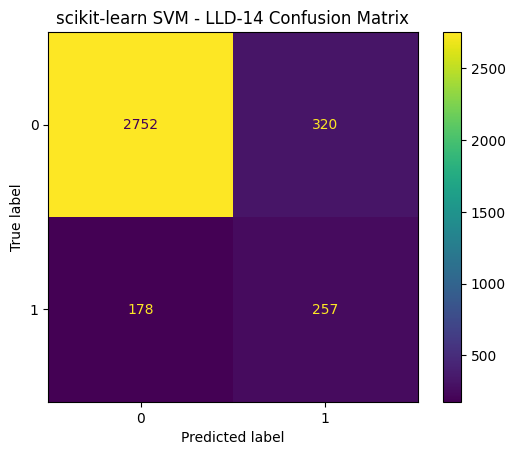



--- Evaluating: KNN on LLD-14 ---

-- scikit-learn KNN --
Accuracy on LLD-14: 0.8754
Prediction Duration: 0.0740 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3072
           1       0.50      0.65      0.56       435

    accuracy                           0.88      3507
   macro avg       0.72      0.78      0.74      3507
weighted avg       0.89      0.88      0.88      3507

Confusion Matrix:
[[2789  283]
 [ 154  281]]


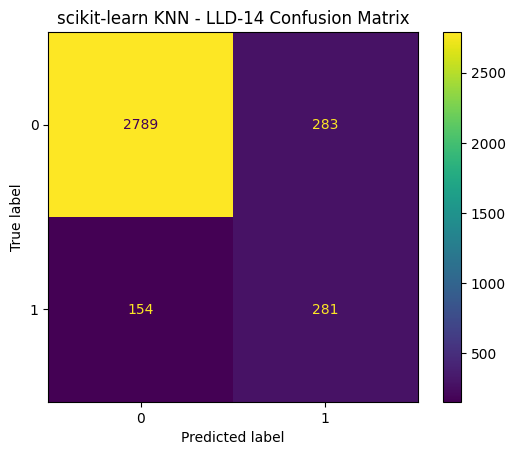



--- Evaluating: RF on LLD-14 ---

-- scikit-learn RF --
Accuracy on LLD-14: 0.9184
Prediction Duration: 0.0181 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3072
           1       0.67      0.67      0.67       435

    accuracy                           0.92      3507
   macro avg       0.81      0.81      0.81      3507
weighted avg       0.92      0.92      0.92      3507

Confusion Matrix:
[[2931  141]
 [ 145  290]]


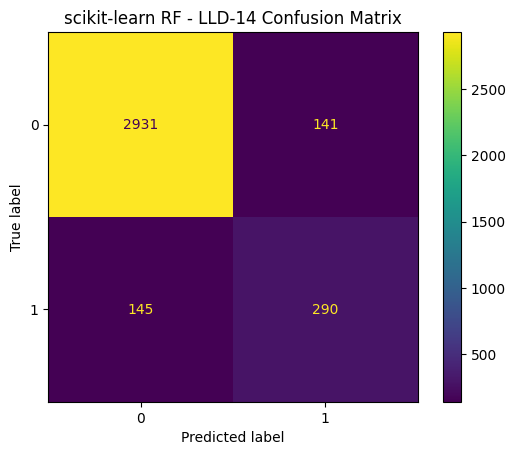



SUMMARY: LLB-10 trained models performance on all test wells

LLD-14 Results:
  scikit-learn Accuracies: {'SVM': 0.8579982891360137, 'KNN': 0.8753920729968634, 'RF': 0.9184488166524095}
  scikit-learn Prediction Times: {'SVM': 0.14369750022888184, 'KNN': 0.07402348518371582, 'RF': 0.018143892288208008}


In [33]:
# Evaluate LLB-10 trained models on all test wells data
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("Evaluating LLB-10 trained models on all test wells data...")
print("="*80)

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} EVALUATION {'='*20}")
    
    # Initialize accuracy dictionaries for this well
    test_wells_accuracy[well_name_test] = {}
    
    for model_name in models.keys():
        print(f"\n--- Evaluating: {model_name} on {well_name_test} ---")
        
        # --- scikit-learn model evaluation ---
        if model_name in test_wells_pred[well_name_test]:
            print(f"\n-- scikit-learn {model_name} --")
            
            # Calculate accuracy
            accuracy_sk = accuracy_score(test_wells_true_labels[well_name_test], test_wells_pred[well_name_test][model_name])
            test_wells_accuracy[well_name_test][model_name] = accuracy_sk
            print(f"Accuracy on {well_name_test}: {accuracy_sk:.4f}")
            
            # Prediction time
            print(f"Prediction Duration: {test_wells_pred_times[well_name_test][model_name]:.4f} seconds")

            # Classification report
            print("Classification Report:")
            print(classification_report(test_wells_true_labels[well_name_test], test_wells_pred[well_name_test][model_name]))

            # Confusion Matrix
            print("Confusion Matrix:")
            cm_sk = confusion_matrix(test_wells_true_labels[well_name_test], test_wells_pred[well_name_test][model_name])
            print(cm_sk)
            
            # Plot confusion matrix
            disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=[0, 1])
            disp_sk.plot()
            plt.title(f"scikit-learn {model_name} - {well_name_test} Confusion Matrix")
            plt.show()
        
        
        
        print("\n" + "="*40)

print("\n" + "="*80)
print("SUMMARY: LLB-10 trained models performance on all test wells")
print("="*80)
for well_name_test in test_wells:
    print(f"\n{well_name_test} Results:")
    print(f"  scikit-learn Accuracies: {test_wells_accuracy[well_name_test]}")
    print(f"  scikit-learn Prediction Times: {test_wells_pred_times[well_name_test]}")


==================== LLD-14 VISUALIZATION ====================


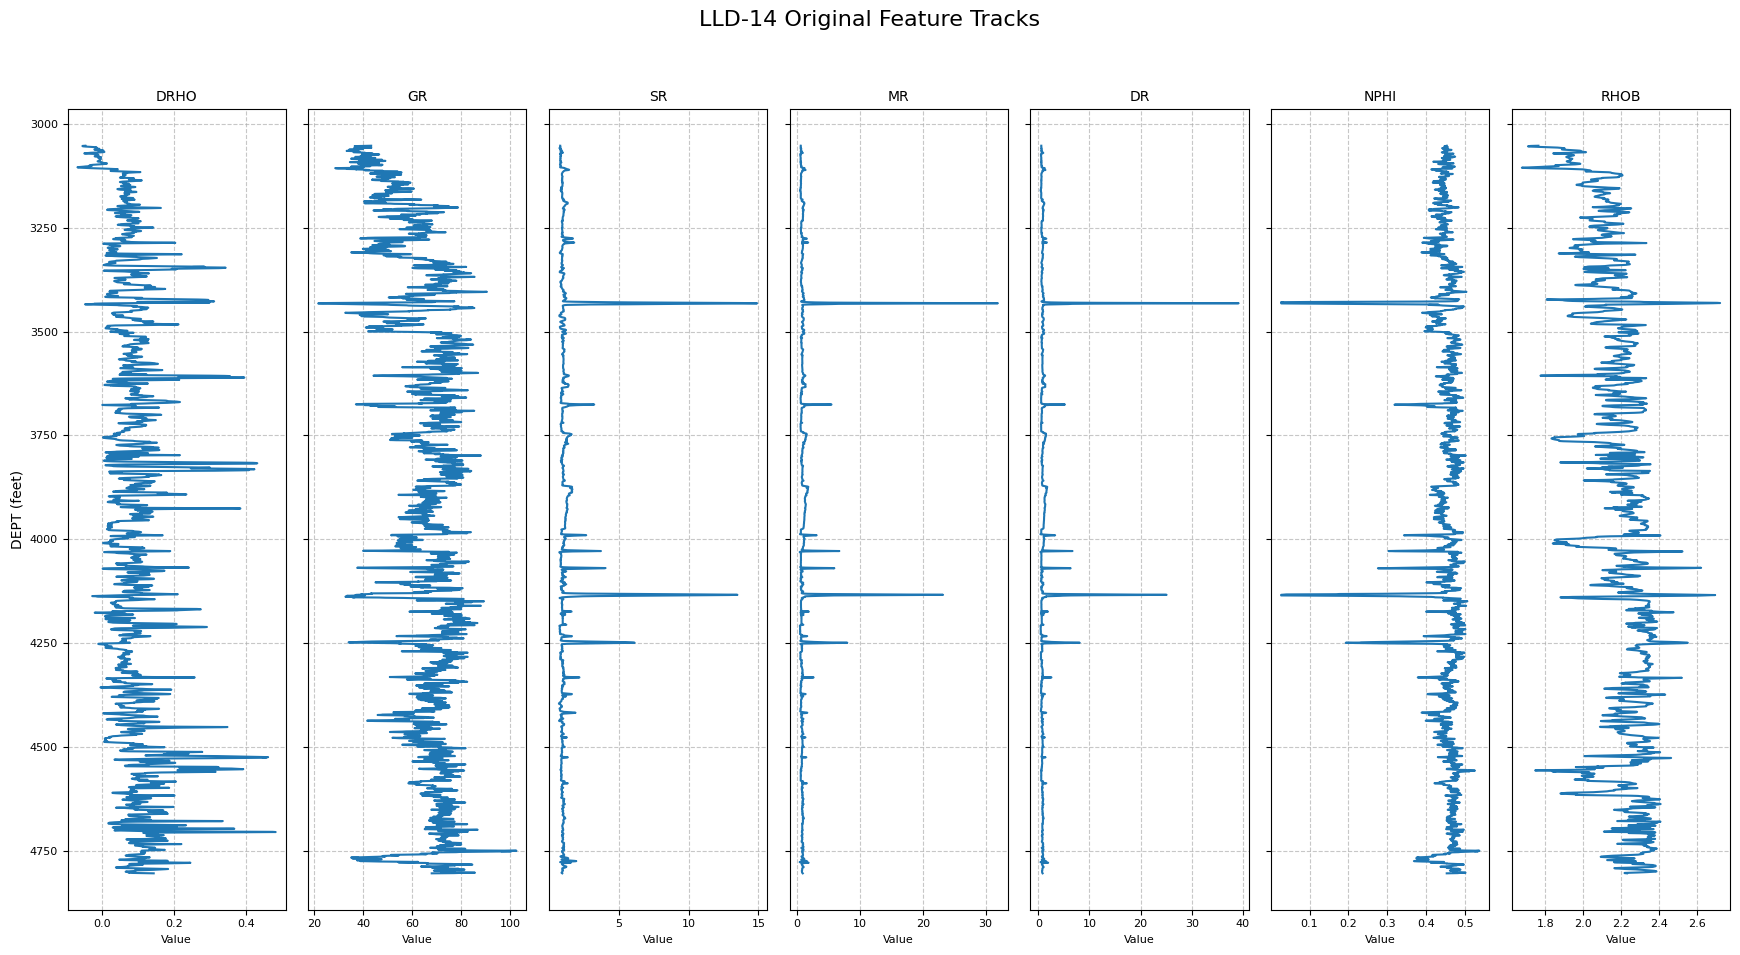

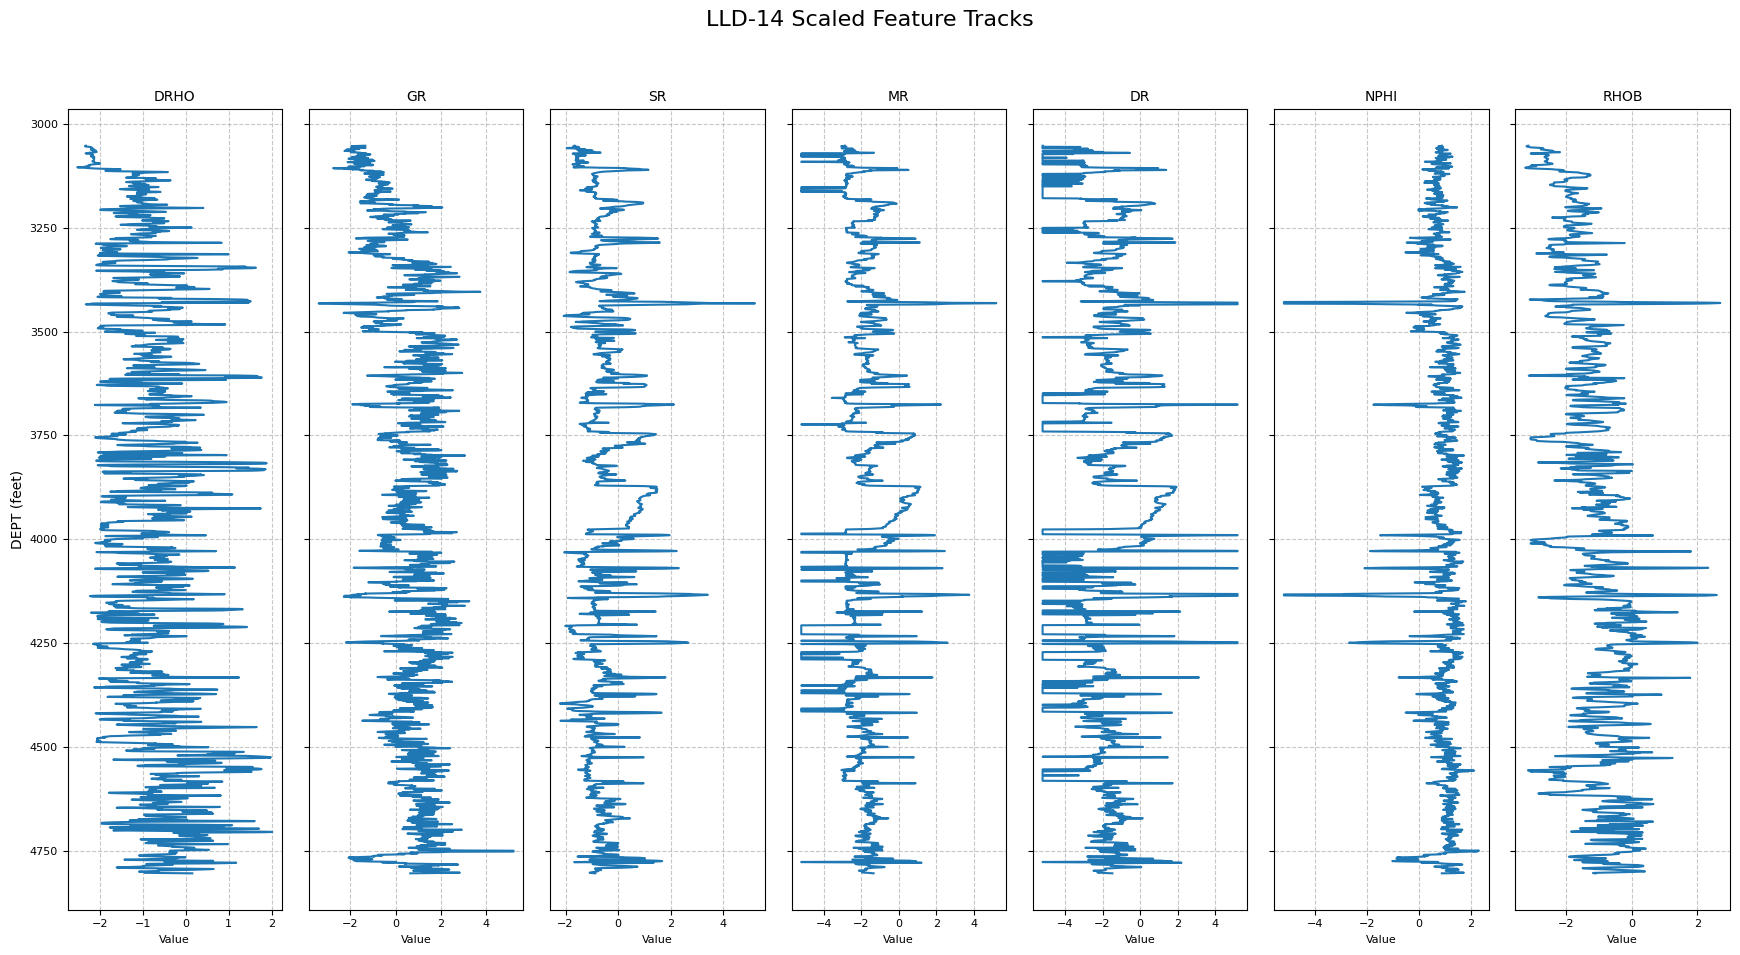

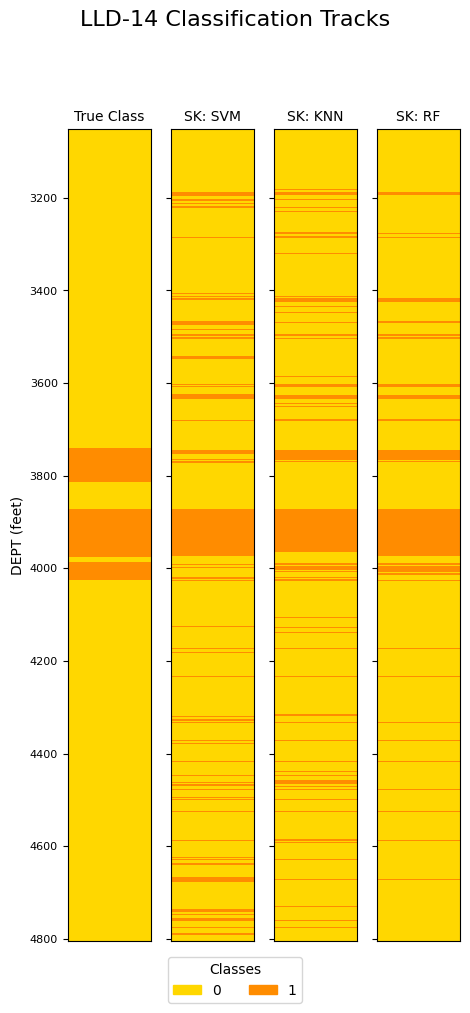

In [34]:
# Create visualization plots for all test wells data and predictions
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} VISUALIZATION {'='*20}")
    
    if 'DEPT' not in test_wells_data[well_name_test].columns:
        print(f"Error: 'DEPT' column not found in {well_name_test} data DataFrame. Cannot generate depth plots.")
        continue
    
    depth_column_test = test_wells_data[well_name_test]['DEPT']
    feature_names = test_wells_features[well_name_test].columns.tolist()

    # Prepare labels and predictions for this test well
    true_labels_test = test_wells_true_labels[well_name_test]
    all_predictions_test_to_plot = {}
    all_predictions_test_to_plot['True Labels'] = true_labels_test
    
    # Add scikit-learn predictions
    for model_name, preds in test_wells_pred[well_name_test].items():
        all_predictions_test_to_plot[f'SK: {model_name}'] = preds


    # Define colors for classes
    if isinstance(true_labels_test, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels_test))
    else:
        unique_classes = np.sort(true_labels_test.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])

    # --- Figure 1: Original Feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features = [axes_features]
        fig_features.suptitle(f"{well_name_test} Original Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(test_wells_data[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 2: Scaled Feature Tracks ---
    if num_feature_plots > 0:
        fig_features_scaled, axes_features_scaled = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features_scaled = [axes_features_scaled]
        fig_features_scaled.suptitle(f"{well_name_test} Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features_scaled[i]
            ax.plot(test_wells_features_scaled[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features_scaled[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_test_to_plot)
    if num_classification_plots > 0:
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle(f"{well_name_test} Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_test_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_test_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=test_wells_features_scaled[well_name_test].index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column_test.max(), depth_column_test.min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)

        # axes_class[0].invert_yaxis()

        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print(f"No classification data to plot for {well_name_test}.")

In [35]:
# Create a simple comparison summary for training and test wells performance using scikit-learn models
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("PERFORMANCE SUMMARY: LLB-10 and TEST WELLS (scikit-learn)")
print("="*80)

# --- Accuracy and timing on LLB-10 ---
summary_rows = []
for model_name in models.keys():
    row = {
        'Model': model_name,
        'LLB-10_Train_Acc': train_accuracy.get(model_name, 'N/A'),
        'LLB-10_Test_Acc': test_accuracy.get(model_name, 'N/A'),
        'LLB-10_CV': crossValidation_accuracy.get(model_name, 'N/A'),
        'LLB-10_Train_Time(s)': times.get(model_name, 'N/A'),
        'LLB-10_Pred_Time(s)': pred_times.get(model_name, 'N/A'),
    }
    # Add test wells metrics if available
    for well_name_test in test_wells:
        acc = None
        pred_t = None
        if well_name_test in test_wells_accuracy and model_name in test_wells_accuracy[well_name_test]:
            acc = test_wells_accuracy[well_name_test][model_name]
        if well_name_test in test_wells_pred_times and model_name in test_wells_pred_times[well_name_test]:
            pred_t = test_wells_pred_times[well_name_test][model_name]
        row[f'{well_name_test}_Test_Acc'] = acc if acc is not None else 'N/A'
        row[f'{well_name_test}_Pred_Time(s)'] = pred_t if pred_t is not None else 'N/A'
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\nPerformance Summary Table:")
print(summary_df.to_string(index=False))


PERFORMANCE SUMMARY: LLB-10 and TEST WELLS (scikit-learn)

Performance Summary Table:
Model  LLB-10_Train_Acc  LLB-10_Test_Acc  LLB-10_CV  LLB-10_Train_Time(s)  LLB-10_Pred_Time(s)  LLD-14_Test_Acc  LLD-14_Pred_Time(s)
  SVM          0.981185         0.969993   0.977179              5.513788             0.236633         0.857998             0.143698
  KNN          1.000000         0.962317   0.974292              0.695637             0.072058         0.875392             0.074023
   RF          1.000000         0.972087   0.980160             25.994238             0.034257         0.918449             0.018144


# Layer by layer Hydrocarbon analysis


This section segregates the machine learning results for a well based on the predefined `layer_boundaries`. For each layer, it calculates the percentage of data points classified as hydrocarbon-positive (class 1). A layer is designated as 'Hydrocarbon' if this percentage is greater than `hydrocarbon_percentage_threshold`, and 'Non-Hydrocarbon' otherwise.


In [36]:
hydrocarbon_percentage_threshold = 25

## Layer boundaries

In [37]:
layer_boundaries = {}
layer_boundaries['LLB-10'] = [
    2199,
    2249,
    2556,
    2693,
    2726,
    2871,
    2886,
    2957,
    2978,
    3052,
    3078,
    3155,
    3197,
    3399,
    3408,
    3568,
    3644,
    3658,
    3738,
    3772,
    3811,
    3873,
    3937,
    3957,
    3969,
    4005,
    4183,
    4198,
    4204,
    4217,
    4321,
    4410,
    4497,
    4632,
    4643,
    4697,
    4875,
    4891,
    4915,
    4928,
    5031,
    5041,
    5124,
    5144,
    5170,
    5190,
    5309,
    5384,
    5444,
    5468,
    5734,
    5764,
    5791,
    5839,
    5901,
    5951,
    6073,
    6095,
    6102,
    6123,
    6137,
    6323,
    6421,
    6683,
    6720,
    6976,
    7148,
    7362,
    7529,
    7547,
    7554,
    8736,
    8779,
    8854,
    8873,
    9049,
    9166,
    9228,
    9233,
    9282,
    9284,
    9290,
    9372,
    9399,
    9420,
    9432,
    9441,
    9463,
    9475,
    9483,
    9504,
    9547,
    9558,
    9625,
    9671,
    9685,
    9734,
    9740,
    9802,
    9828,
    9838,
    9870,
    9881,
    9892,
    9914,
    9926,
    9970,
    10019,
    10123,
    10151,
    10185,
    10237,
    10242,
    10245,
    10349,
    10381,
    10394,
    10429,
    10480,
    10505,
    10534,
    10543,
    10571,
    10578,
    10583
]
layer_boundaries['LLA-2'] = [
    3380,
    3493,
    3509,
    3583,
    3603,
    3674,
    3758,
    3859,
    3888,
    3903,
    3957,
    4063,
    4089,
    4123,
    4218,
    4290,
    4366,
    4433,
    4556,
    4566,
    4613,
    4753,
    4769,
    4793,
    4799,
    4887,
    4895,
    4997,
    5019,
    5031,
    5047,
    5142,
    5205,
    5231,
    5257,
    5490,
    5512,
    5540,
    5617,
    5639,
    5659,
    5682,
    5687,
    5724,
    5765,
    5772,
    5901,
    5911,
    5980,
    6030,
    6207,
    6215,
    6367,
    6470,
    6484,
    6576,
    6585,
    6622,
    6631,
    6636,
    6727,
    6782
]
layer_boundaries['LLD-14'] = [
    1908,
    1968,
    2166,
    2284,
    2310,
    2418,
    2434,
    2489,
    2505,
    2542,
    2569,
    2657,
    2663,
    2803,
    2881,
    3009,
    3100,
    3114,
    3184,
    3210,
    3274,
    3324,
    3407,
    3439,
    3448,
    3483,
    3602,
    3637,
    3642,
    3684,
    3740,
    3814,
    3872,
    3976,
    3988,
    4026,
    4131,
    4143,
    4173,
    4176,
    4204,
    4208,
    4243,
    4254,
    4265,
    4272,
    4414,
    4480,
    4582,
    4598,
    4754,
    4782,
    4804,
    4862,
    4871,
    4928,
    4932,
    4995,
    5028,
    5077,
    5085,
    5206,
    5230,
    5303,
    5385,
    5538,
    5559,
    5894,
    5940,
    6015,
    6089,
    6106,
    6175,
    6487,
    6766,
    7046,
    7089,
    7155,
    7240,
    7337,
    7458,
    7521,
    7563,
    7566,
    7630,
    7646,
    7650,
    7657,
    7663,
    7666,
    7690,
    7716,
    7729,
    7762,
    7807,
    7839,
    7851,
    7886,
    7898,
    7956,
    7976,
    7993,
    8018,
    8066,
    8072,
    8083,
    8106,
    8130,
    8139,
    8227,
    8266,
    8287
]

## End of layer boundaries

In [38]:
# Modular functions for layer-by-layer analysis

def prepare_results_dataframe(data_df, true_labels, sk_predictions):
    """
    Prepare a combined dataframe with depth, true labels, and all predictions.

    Args:
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions

    Returns:
        DataFrame with all combined data
    """
    results_df = data_df[['DEPT']].copy()
    results_df['True_Labels'] = true_labels

    # Add scikit-learn predictions
    for model_name, preds in sk_predictions.items():
        results_df[f'SK_{model_name}'] = preds

    return results_df

def analyze_layers(results_df, boundaries, threshold):
    """
    Analyze hydrocarbon percentage for each layer.

    Args:
        results_df: DataFrame with DEPT and prediction columns
        boundaries: List of layer boundary depths
        threshold: Hydrocarbon percentage threshold for classification

    Returns:
        DataFrame with layer analysis results
    """
    layer_analysis_results = []

    for i in range(len(boundaries) - 1):
        start_depth = boundaries[i]
        end_depth = boundaries[i+1]

        # Filter data for the current layer
        layer_data = results_df[(results_df['DEPT'] >= start_depth) & (results_df['DEPT'] < end_depth)]

        if not layer_data.empty:
            layer_info = {
                'Layer': f"{i+1}",
                'Start_Depth': start_depth,
                'End_Depth': end_depth
            }

            # Analyze each prediction column
            for col in results_df.columns:
                if col not in ['DEPT']:
                    hydrocarbon_percentage = layer_data[col].mean() * 100
                    classification = 'Hydrocarbon' if hydrocarbon_percentage > threshold else 'Non-Hydrocarbon'
                    layer_info[f'{col}_HC_%'] = f"{hydrocarbon_percentage:.2f}%"
                    layer_info[f'{col}_Class'] = classification

            layer_analysis_results.append(layer_info)

    return pd.DataFrame(layer_analysis_results)

def analyze_well_layers(well_name, data_df, true_labels, sk_predictions, boundaries, threshold):
    """
    Complete layer analysis for a single well.

    Args:
        well_name: Name of the well (e.g., 'LLB-10', 'LLD-14')
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions
        boundaries: List of layer boundary depths for this well
        threshold: Hydrocarbon percentage threshold for classification

    Returns:
        DataFrame with layer analysis results
    """
    results_df = prepare_results_dataframe(data_df, true_labels, sk_predictions)
    layer_summary = analyze_layers(results_df, boundaries, threshold)
    return layer_summary

def plot_layer_classification_for_well(layer_summary_results, well_name):
    """
    Create visualization for layer-by-layer classification for a specific well.

    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells
        well_name: Name of the well to plot
    """
    if well_name not in layer_summary_results:
        print(f"No layer analysis data found for {well_name}")
        return

    layer_summary_df = layer_summary_results[well_name]

    # Get the list of classification columns to plot
    class_cols = [col for col in layer_summary_df.columns if col.endswith('_Class')]

    # Define colors for the plot
    color_map = {'Non-Hydrocarbon': 'gold', 'Hydrocarbon': 'darkorange'}

    num_plots = len(class_cols)
    if num_plots > 0:
        fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 1.2, 10), sharey=True)
        if num_plots == 1:
            axes = [axes]
        fig.suptitle(f'{well_name} Layer-by-Layer Aggregated Classification', fontsize=16, y=0.98)

        for i, col_name in enumerate(class_cols):
            ax = axes[i]

            # Iterate over each layer in the summary dataframe
            for idx, row in layer_summary_df.iterrows():
                start_depth = row['Start_Depth']
                end_depth = row['End_Depth']
                classification = row[col_name]

                # Get the color for the classification
                color = color_map.get(classification, 'white')

                # Draw a colored block for the layer
                ax.axhspan(start_depth, end_depth, color=color, alpha=1)

            # Formatting the plot
            model_title = col_name.replace('_Class', '').replace('_', ' ')
            ax.set_title(model_title, fontsize=10)
            ax.set_xticks([])
            ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)

            # Set depth limits based on the full range of layers
            ax.set_ylim(layer_summary_df['End_Depth'].max(), layer_summary_df['Start_Depth'].min())

        # Create a legend
        patches = [plt.Rectangle((0,0),1,1, color=color_map[cls]) for cls in color_map]
        legend_labels = list(color_map.keys())
        fig.legend(patches, legend_labels, loc='lower center', ncol=len(legend_labels), 
                  bbox_to_anchor=(0.5, -0.02), title="Layer Classification")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"No layer classification summary data to plot for {well_name}.")

def calculate_all_layer_accuracies(layer_summary_results):
    """
    Calculate layer-level accuracy for each model across all wells.

    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells

    Returns:
        Dictionary with well names as keys and model accuracies as values
    """
    all_accuracies = {}

    for well_name, layer_summary_df in layer_summary_results.items():
        true_layer_classes = layer_summary_df['True_Labels_Class']
        pred_class_cols = [col for col in layer_summary_df.columns 
                          if col.endswith('_Class') and col != 'True_Labels_Class']

        well_accuracies = {}
        for col in pred_class_cols:
            pred_layer_classes = layer_summary_df[col]
            accuracy = accuracy_score(true_layer_classes, pred_layer_classes)
            model_key = col.replace('_Class', '')
            well_accuracies[model_key] = accuracy

        all_accuracies[well_name] = well_accuracies

    return all_accuracies

def print_comprehensive_layer_accuracy_analysis(all_layer_accuracies):
    """
    Print comprehensive layer accuracy analysis for all wells.

    Args:
        all_layer_accuracies: Dictionary with well names as keys and model accuracies as values
    """
    print("LAYER-LEVEL ACCURACY ANALYSIS")
    print("="*60)

    # Print individual well accuracies
    for well_name, accuracies in all_layer_accuracies.items():
        print(f"\n{well_name} Layer-Level Accuracy:")
        print("-" * 30)
        for model_key, accuracy in accuracies.items():
            print(f"{model_key}: {accuracy:.4f}")

    # Create summary comparison if we have multiple wells
    well_names = list(all_layer_accuracies.keys())
    if len(well_names) >= 2:
        print("\n" + "="*60)
        print("LAYER-LEVEL ACCURACY COMPARISON SUMMARY")
        print("="*60)

        # Get all unique model keys
        all_model_keys = set()
        for accuracies in all_layer_accuracies.values():
            all_model_keys.update(accuracies.keys())

        summary_data = []
        for model_key in sorted(all_model_keys):
            row = {'Model': model_key}
            for well_name in well_names:
                if model_key in all_layer_accuracies[well_name]:
                    row[f'{well_name} Layer Accuracy'] = all_layer_accuracies[well_name][model_key]
                else:
                    row[f'{well_name} Layer Accuracy'] = 'N/A'
            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))


## LLB-10

In [39]:
# Initialize layer summary results object
layer_summary_results = {}

# Analyze LLB-10 layers using modular functions
layer_summary_results['LLB-10'] = analyze_well_layers(
    well_name='LLB-10',
    data_df=data,
    true_labels=y,
    sk_predictions=pred,
    boundaries=layer_boundaries['LLB-10'],
    threshold=hydrocarbon_percentage_threshold
)

# Display the summary table
print(f"LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
display(layer_summary_results['LLB-10'])

LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class
0,18,3658,3738,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,19,3738,3772,0.00%,Non-Hydrocarbon,16.18%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,20,3772,3811,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,21,3811,3873,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
4,22,3873,3937,0.00%,Non-Hydrocarbon,1.56%,Non-Hydrocarbon,0.78%,Non-Hydrocarbon,0.78%,Non-Hydrocarbon
5,23,3937,3957,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
6,24,3957,3969,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,25,3969,4005,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
8,26,4005,4183,0.00%,Non-Hydrocarbon,4.78%,Non-Hydrocarbon,1.12%,Non-Hydrocarbon,0.56%,Non-Hydrocarbon
9,27,4183,4198,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon


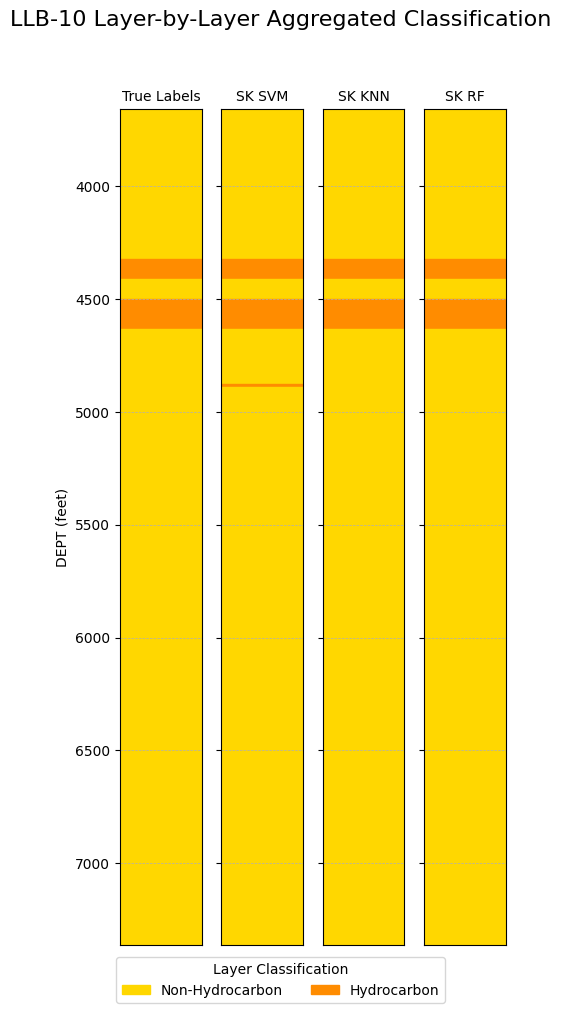

In [40]:
# Visualize LLB-10 layer classification
plot_layer_classification_for_well(layer_summary_results, 'LLB-10')

## Test Wells Layer Analysis


==================== LLD-14 LAYER ANALYSIS ====================
LLD-14 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class
0,16,3009,3100,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,17,3100,3114,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,17.86%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,18,3114,3184,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,2.86%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,19,3184,3210,0.00%,Non-Hydrocarbon,48.08%,Hydrocarbon,34.62%,Hydrocarbon,25.00%,Non-Hydrocarbon
4,20,3210,3274,0.00%,Non-Hydrocarbon,13.28%,Non-Hydrocarbon,7.03%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
5,21,3274,3324,0.00%,Non-Hydrocarbon,9.00%,Non-Hydrocarbon,21.00%,Non-Hydrocarbon,8.00%,Non-Hydrocarbon
6,22,3324,3407,0.00%,Non-Hydrocarbon,0.60%,Non-Hydrocarbon,3.61%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,23,3407,3439,0.00%,Non-Hydrocarbon,28.12%,Hydrocarbon,29.69%,Hydrocarbon,25.00%,Non-Hydrocarbon
8,24,3439,3448,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
9,25,3448,3483,0.00%,Non-Hydrocarbon,21.43%,Non-Hydrocarbon,7.14%,Non-Hydrocarbon,12.86%,Non-Hydrocarbon


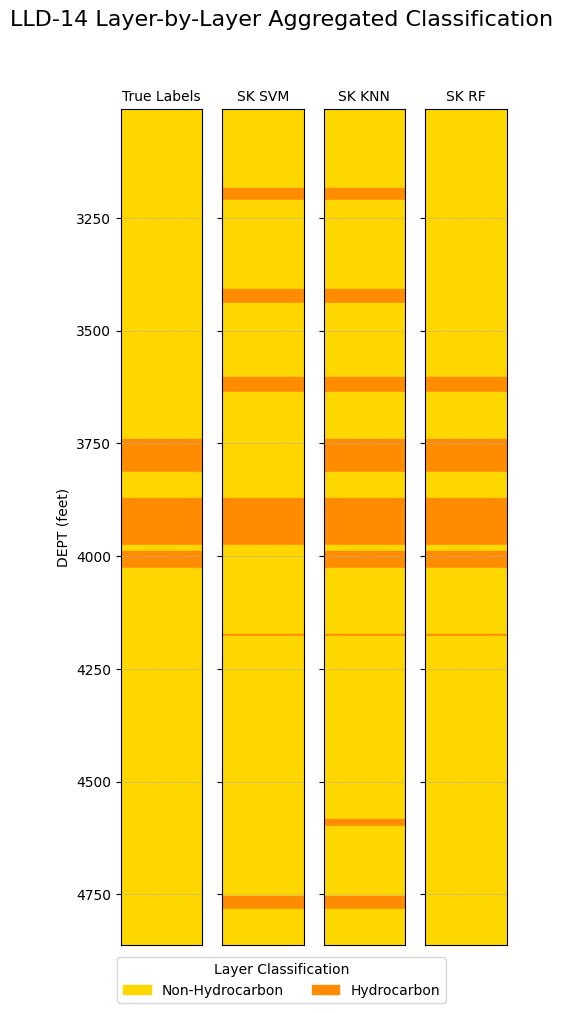

In [41]:
# Analyze layers for all test wells using modular functions
for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} LAYER ANALYSIS {'='*20}")
    
    # Check if layer boundaries exist for this well
    if well_name_test not in layer_boundaries:
        print(f"Warning: No layer boundaries defined for {well_name_test}. Skipping layer analysis.")
        continue
    
    layer_summary_results[well_name_test] = analyze_well_layers(
        well_name=well_name_test,
        data_df=test_wells_data[well_name_test],
        true_labels=test_wells_true_labels[well_name_test],
        sk_predictions=test_wells_pred[well_name_test],
        boundaries=layer_boundaries[well_name_test],
        threshold=hydrocarbon_percentage_threshold,
    )

    # Display the summary table
    print(f"{well_name_test} Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
    display(layer_summary_results[well_name_test])
    
    # Visualize layer classification
    plot_layer_classification_for_well(layer_summary_results, well_name_test)

## Resulting Model Accuracy 

In [42]:
# Calculate and display layer-level accuracies using modular functions
all_layer_accuracies = calculate_all_layer_accuracies(layer_summary_results)
print_comprehensive_layer_accuracy_analysis(all_layer_accuracies)

LAYER-LEVEL ACCURACY ANALYSIS

LLB-10 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.9800
SK_KNN: 1.0000
SK_RF: 1.0000

LLD-14 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.8158
SK_KNN: 0.8421
SK_RF: 0.9474

LAYER-LEVEL ACCURACY COMPARISON SUMMARY
 Model  LLB-10 Layer Accuracy  LLD-14 Layer Accuracy
SK_KNN                   1.00               0.842105
 SK_RF                   1.00               0.947368
SK_SVM                   0.98               0.815789


In [43]:
# Execution time
end_notebook = time.time()
print(f"Total notebook execution time: {end_notebook - start_notebook:.2f} seconds")

Total notebook execution time: 38.29 seconds
